In [5]:
# Imports:
import pandas as pd
import numpy as np
import re

art_filepath = "S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_all_deduplicated_postselected_articles.csv"
cmt_filepath = "S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_all_deduplicated_comments.csv"
    
raw_article_df = pd.read_csv(art_filepath, sep=";")
raw_article_df = raw_article_df[raw_article_df['selected'] == 1].reset_index(drop=True) #Note: Article data was filtered before (also by hand)

raw_comment_df = pd.read_csv(cmt_filepath).sort_values(by=['article_id', 'level', 'date'], ascending=[True, True, True])
raw_comment_df.drop_duplicates(subset=['article_id', 'body'], keep='first', inplace=True) #Remove duplicate comments
raw_comment_df = raw_comment_df[raw_comment_df["article_id"].isin(raw_article_df["article_id"])].reset_index(drop=True) #Remove comments that are not in the article set; did not do that yet after article postselection
raw_comment_df = raw_comment_df[raw_comment_df['level'] == 0].reset_index(drop=True)


In [15]:
print(len(raw_article_df), len(raw_comment_df))
len(raw_article_df['body'].values)

217 14527


217

In [16]:
# Preprocess the selected data

def preprocess_article_text(article_bodies):
    #Remove multiple newlines
    rm_multinewlines = lambda s: re.sub(r'(\n+\s*\n+)+' , r'\n', s)
    out_article_bodies = [ rm_multinewlines(art_body) for art_body in article_bodies ]
    return np.array(out_article_bodies)

def preprocess_comment_text(comment_bodies):
    #Remove links/urls
    rm_urls = lambda s: re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', r'', s)

    #Remove emojis and other non-ascii characters
    rm_emojis = lambda s: re.sub(r'[^\x00-\x7F]+', r'',  rm_urls(s)) # 

    #Remove multiple newlines
    rm_multinewlines = lambda s: re.sub(r'(\n+\s*\n+)+' , r'\n', rm_emojis(s)) #

    #Remove multiple spaces
    rm_multispaces = lambda s: re.sub(r'(\s\s+)' , r' ', rm_multinewlines(s))
    
    #Perform all the operations above in one go
    return np.array([rm_multispaces(cmt_body) for cmt_body in comment_bodies])

raw_article_df['body'] = preprocess_article_text(raw_article_df['body'].values)
print("Done with the articles. Now the comments...")

raw_comment_df['body'] = preprocess_comment_text(raw_comment_df['body'].values)

Done with the articles. Now the comments...


In [17]:
# Select relevant / valid datapoints from the pre-selected raw data
ps_article_df = raw_article_df

# Delete empty comments which have not at least one non-special character (i.e. letter or number) in their body text
ps_comment_df = raw_comment_df[raw_comment_df['body'].str.contains(r'[a-zA-Z0-9]')]

# Delete comments by bots or moderators, pre-surveyed: "AutoModerator", "FuturologyBot", "CivilServantBot", "SEP-Bot", "AmputatorBot", "OtherAMPBot"
bot_user_list = ["AutoModerator", "FuturologyBot", "CivilServantBot", "SEP-Bot", "AmputatorBot", "OtherAMPBot"]
ps_comment_df = ps_comment_df[~ps_comment_df['username'].isin(bot_user_list)]

for art_id in ps_article_df['article_id'].values:
    if len(ps_comment_df[ps_comment_df['article_id'] == art_id]) != ps_article_df[ps_article_df['article_id'] == art_id]['num_tld_comments'].values[0]:
        print("Found one")
        ps_article_df.loc[ps_article_df['article_id'] == art_id, "num_tld_comments"] = len(ps_comment_df[ps_comment_df['article_id'] == art_id])

ps_article_df.to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_all_articles_complete_preprocessed.csv", sep=";", index=False)
ps_comment_df.to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_all_comments_complete_preprocessed.csv", sep=";", index=False)


Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one
Found one


Number of articles and comments in the dataset:
Articles: 123
Comments: 4920
Comments per article:  Axes(0.125,0.11;0.775x0.77)


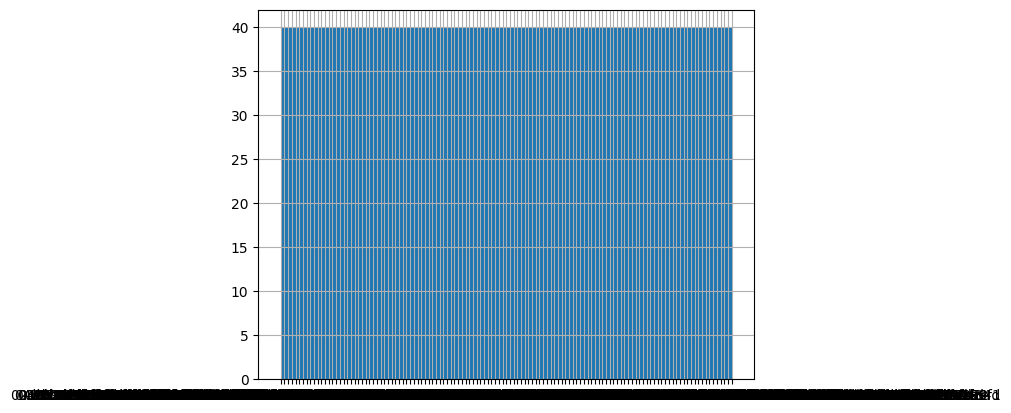

In [18]:
# Create a stratified, complete (i.e. not splitted) dataset for annotation and training purposes
# Note: The dataset is stratified by the number of comments per article, i.e. the number of comments per article is the same.

def stratified_dataset(num_cmts_per_art, SEED):
    
    strat_article_df = ps_article_df[ps_article_df['num_tld_comments'] >= num_cmts_per_art].reset_index(drop=True)
    strat_article_df.to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_art_stratified.csv", sep=";")
    assert len(strat_article_df["article_id"]) == len(np.unique(strat_article_df["article_id"]))

    sampled_cmts = []
    for art_id in strat_article_df["article_id"]:
        art_cmt_df = ps_comment_df[ps_comment_df["article_id"] == art_id].reset_index(drop=True)
        #print(len(art_cmt_df))
        sampled_art_cmts = art_cmt_df.sample(n=num_cmts_per_art, random_state = SEED) 

        sampled_cmts.append(sampled_art_cmts.reset_index(drop=True))

    strat_comment_df = pd.concat(sampled_cmts, ignore_index=True).sort_values(by=['article_id', 'level', 'date'], ascending=[True, True, True])
    strat_comment_df.to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_cmt_stratified.csv", sep=";")

    print("Number of articles and comments in the dataset:")
    print("++++++++++++++++++++++++++++++++++++++++=")
    print("Articles: " + str(len(strat_article_df)))
    print("Comments: " + str(len(strat_comment_df)))
    print("Comments per article: ", strat_comment_df["article_id"].hist(bins=len(strat_article_df)))
    print("++++++++++++++++++++++++++++++++++++++++=")

SEED = 42
num_cmts_per_art = 40

stratified_dataset(num_cmts_per_art, SEED)

In [19]:
# Create a reproducable set of train, validation and evaluation datasets t.b. used in the models

def split_between_articles(set_fracs, SEED):
    train_size = int(len(ps_article_df) * set_fracs["Train"])
    val_size = int(len(ps_article_df) * set_fracs["Validation"])
    eval_size = int(len(ps_article_df) * set_fracs["Evaluation"])
    
    train_article_df = ps_article_df.sample(n=train_size, random_state = SEED)
    non_train_article_df = ps_article_df.drop(train_article_df.index).reset_index(drop=True)

    val_article_df = non_train_article_df.sample(n=val_size, random_state = SEED)
    eval_article_df = non_train_article_df.drop(val_article_df.index).reset_index(drop=True)

    train_article_df.reset_index(drop=True).to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_art_train_artsplit.csv", sep=";")
    val_article_df.reset_index(drop=True).to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_art_val_artsplit.csv", sep=";")
    eval_article_df.reset_index(drop=True).to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_art_eval_artsplit.csv", sep=";")

    train_comment_df = ps_comment_df[ps_comment_df['article_id'].isin(train_article_df['article_id'])].reset_index(drop=True).sort_values(by=['article_id', 'level', 'date'], ascending=[True, True, True])
    val_comment_df = ps_comment_df[ps_comment_df['article_id'].isin(val_article_df['article_id'])].reset_index(drop=True).sort_values(by=['article_id', 'level', 'date'], ascending=[True, True, True])
    eval_comment_df = ps_comment_df[ps_comment_df['article_id'].isin(eval_article_df['article_id'])].reset_index(drop=True).sort_values(by=['article_id', 'level', 'date'], ascending=[True, True, True])
    
    train_comment_df.to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_cmt_train_artsplit.csv", sep=";")
    val_comment_df.to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_cmt_val_artsplit.csv", sep=";")
    eval_comment_df.to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_cmt_eval_artsplit.csv", sep=";")
    
    print("Number of articles and comments per set for article splitting:")
    print("=========================================")
    print("Train articles: " + str(len(train_article_df)))
    print("Validation articles: " + str(len(val_article_df)))
    print("Evaluation articles: " + str(len(eval_article_df)))
    print("Train comments: " + str(len(train_comment_df)))
    print("Validation comments: " + str(len(val_comment_df)))
    print("Evaluation comments: " + str(len(eval_comment_df)))
    print("=========================================")
    
def split_within_articles(set_fracs, SEED):
    train_article_df = ps_article_df
    val_article_df = ps_article_df
    eval_article_df = ps_article_df

    train_article_df.to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_art_train_cmtsplit.csv", sep=";")
    val_article_df.to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_art_val_cmtsplit.csv", sep=";")
    eval_article_df.to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_art_eval_cmtsplit.csv", sep=";")
    
    train_cmts = []
    val_cmts = []
    eval_cmts = []
    
    for art_id in ps_article_df["article_id"]:
        art_cmt_df = ps_comment_df[ps_comment_df["article_id"] == art_id].reset_index(drop=True)
        num_art_cmts = len(art_cmt_df)
        
        train_size = int(num_art_cmts * set_fracs["Train"])
        val_size = int(num_art_cmts * set_fracs["Validation"])
        eval_size = int(num_art_cmts * set_fracs["Evaluation"])
        
        train_art_cmts = art_cmt_df.sample(n=train_size, random_state = SEED) 
        non_train_art_cmts = art_cmt_df.drop(train_art_cmts.index).reset_index(drop=True)
        
        val_art_cmts = non_train_art_cmts.sample(n=val_size, random_state = SEED)
        eval_art_cmts = non_train_art_cmts.drop(val_art_cmts.index)
        
        train_cmts.append(train_art_cmts.reset_index(drop=True))
        val_cmts.append(val_art_cmts.reset_index(drop=True))
        eval_cmts.append(eval_art_cmts.reset_index(drop=True))
        
    train_comment_df = pd.concat(train_cmts, ignore_index=True).sort_values(by=['article_id', 'level', 'date'], ascending=[True, True, True])
    val_comment_df = pd.concat(val_cmts, ignore_index=True).sort_values(by=['article_id', 'level', 'date'], ascending=[True, True, True])
    eval_comment_df = pd.concat(eval_cmts, ignore_index=True).sort_values(by=['article_id', 'level', 'date'], ascending=[True, True, True])
    
    train_comment_df.to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_cmt_train_cmtsplit.csv", sep=";")
    val_comment_df.to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_cmt_val_cmtsplit.csv", sep=";")
    eval_comment_df.to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_cmt_eval_cmtsplit.csv", sep=";")
    
    print("Number of articles and comments per set for comment splitting:")
    print("=========================================")
    print("Train articles: " + str(len(train_article_df)))
    print("Validation articles: " + str(len(val_article_df)))
    print("Evaluation articles: " + str(len(eval_article_df)))
    print("Train comments: " + str(len(train_comment_df)))
    print("Validation comments: " + str(len(val_comment_df)))
    print("Evaluation comments: " + str(len(eval_comment_df)))
    print("=========================================")
    
def split_simple_random(set_fracs, SEED):
    train_size = int(len(ps_comment_df) * set_fracs["Train"])
    val_size = int(len(ps_comment_df) * set_fracs["Validation"])
    eval_size = int(len(ps_comment_df) * set_fracs["Evaluation"])
    
    train_comment_df = ps_comment_df.sample(n=train_size, random_state = SEED)
    non_train_comment_df = ps_comment_df.drop(train_comment_df.index).reset_index(drop=True)
    
    val_comment_df = non_train_comment_df.sample(n=val_size, random_state = SEED)
    eval_comment_df = non_train_comment_df.drop(val_comment_df.index).reset_index(drop=True)

    train_comment_df.reset_index(drop=True).to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_cmt_train_simplesplit.csv", sep=";")
    val_comment_df.reset_index(drop=True).to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_cmt_val_simplesplit.csv", sep=";")
    eval_comment_df.reset_index(drop=True).to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_cmt_eval_simplesplit.csv", sep=";")

    train_article_df = ps_article_df[ps_article_df['article_id'].isin(train_comment_df['article_id'])].reset_index(drop=True)
    val_article_df = ps_article_df[ps_article_df['article_id'].isin(val_comment_df['article_id'])].reset_index(drop=True)
    eval_article_df = ps_article_df[ps_article_df['article_id'].isin(eval_comment_df['article_id'])].reset_index(drop=True)
    
    train_article_df.to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_art_train_simplesplit.csv", sep=";")
    val_article_df.to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_art_val_simplesplit.csv", sep=";")
    eval_article_df.to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_art_eval_simplesplit.csv", sep=";")
    
    print("Number of articles and comments per set for simple random splitting:")
    print("=========================================")
    print("Train articles: " + str(len(train_article_df)))
    print("Validation articles: " + str(len(val_article_df)))
    print("Evaluation articles: " + str(len(eval_article_df)))
    print("Train comments: " + str(len(train_comment_df)))
    print("Validation comments: " + str(len(val_comment_df)))
    print("Evaluation comments: " + str(len(eval_comment_df)))
    print("=========================================")   

SEED = 42
set_fracs = {"Train": 0.8, "Validation": 0.1, "Evaluation": 0.1}

split_between_articles(set_fracs, SEED)
split_within_articles(set_fracs, SEED)
split_simple_random(set_fracs, SEED)



Number of articles and comments per set for article splitting:
Train articles: 173
Validation articles: 21
Evaluation articles: 23
Train comments: 11979
Validation comments: 1091
Evaluation comments: 1392
Number of articles and comments per set for comment splitting:
Train articles: 217
Validation articles: 217
Evaluation articles: 217
Train comments: 11486
Validation comments: 1340
Evaluation comments: 1636
Number of articles and comments per set for simple random splitting:
Train articles: 217
Validation articles: 213
Evaluation articles: 207
Train comments: 11569
Validation comments: 1446
Evaluation comments: 1447


In [2]:
import pandas as pd

def split_between_articles_limited(max_num_train_articles, max_num_train_comments_per_article, SEED):
    # Note that for this split type, the evaluation and validation sets are neither limited nor different from the original split
    # we only need to make sure that the training set does not contain any validation or evaluation articles
    pd.read_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\artsplit\\r_art_val_artsplit.csv", sep=";").to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_limited_art_val_artsplit.csv", sep=";")
    pd.read_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\artsplit\\r_cmt_val_artsplit.csv", sep=";").to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_limited_cmt_val_artsplit.csv", sep=";")
    pd.read_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\artsplit\\r_art_eval_artsplit.csv", sep=";").to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_limited_art_eval_artsplit.csv", sep=";")
    pd.read_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\artsplit\\r_cmt_eval_artsplit.csv", sep=";").to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_limited_cmt_eval_artsplit.csv", sep=";")
    
    train_article_df = pd.read_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\artsplit\\r_art_train_artsplit.csv", sep=";")
    filtered_train_article_df = train_article_df[train_article_df['num_tld_comments'] > max_num_train_comments_per_article*2] # Make sure that each article has enough comments to sample from
    limited_train_article_df = filtered_train_article_df.sample(n=max_num_train_articles, random_state = SEED)

    limited_train_article_df.reset_index(drop=True).to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_limited_art_train_artsplit.csv", sep=";")

    train_comment_df = pd.read_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\artsplit\\r_cmt_train_artsplit.csv", sep=";")

    sampled_comments = []
    for art_id in limited_train_article_df['article_id']:
        art_cmt_df = train_comment_df[train_comment_df['article_id'] == art_id]
        sampled_art_cmt_df = art_cmt_df.sample(n=max_num_train_comments_per_article, random_state = SEED)
        sampled_comments.append(sampled_art_cmt_df)
        
    limited_train_comment_df = pd.concat(sampled_comments, ignore_index=True) 
    limited_train_comment_df = limited_train_comment_df.sort_values(by=['article_id', 'level', 'date'], ascending=[True, True, True])

    limited_train_comment_df.reset_index(drop=True).to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_limited_cmt_train_artsplit.csv", sep=";")

    print("Limited number of articles and comments per set for article splitting:")
    print("=========================================")
    print("Train articles: " + str(len(limited_train_article_df)))
    print("Train comments: " + str(len(limited_train_comment_df)))
    print("=========================================")
    
def split_within_articles_limited(max_num_train_articles, max_num_train_comments_per_article,SEED):
    # Also here we do not care too much about different validation and evaluation sets since the articles of the sets overlap (intentionally)
    # and since we only want to limit the number of training articles and comments, not the number of validation and evaluation comments
    # so, yes, the validation and evaluation sets are unportionally large, but that is rather a benefit than a problem
    # Note that we could have pushed the dropped training comments into the validation and evaluation sets, but we do care here more about simplicity than about the little loss of data
    # We only need to filter the dropped articles from the comments list (although they would be ignored later anyway)
    
    train_article_df = pd.read_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\cmtsplit\\r_art_train_cmtsplit.csv", sep=";")
    train_article_df = train_article_df[train_article_df['num_tld_comments'] > 2*int(max_num_train_comments_per_article/0.8)] # Make sure that each article has enough comments to sample from and take into account that we dropped 20% of the comments in previous split
    limited_train_article_df = train_article_df.sample(n=max_num_train_articles, random_state = SEED).reset_index(drop=True)
    limited_val_article_df = limited_train_article_df.copy()
    limited_eval_article_df = limited_train_article_df.copy()
    
    limited_train_article_df.to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_limited_art_train_cmtsplit.csv", sep=";")
    limited_val_article_df.to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_limited_art_val_cmtsplit.csv", sep=";")
    limited_eval_article_df.to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_limited_art_eval_cmtsplit.csv", sep=";")
    
    train_comment_df = pd.read_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\cmtsplit\\r_cmt_train_cmtsplit.csv", sep=";")

    sampled_train_comments = []
    
    for art_id in limited_train_article_df['article_id']:
        art_cmt_df = train_comment_df[train_comment_df['article_id'] == art_id]
        sampled_art_cmt_df = art_cmt_df.sample(n=max_num_train_comments_per_article, random_state = SEED)
        sampled_train_comments.append(sampled_art_cmt_df)
    
    limited_train_comment_df = pd.concat(sampled_train_comments, ignore_index=True)
    limited_train_comment_df = limited_train_comment_df.sort_values(by=['article_id', 'level', 'date'], ascending=[True, True, True])
    limited_train_comment_df.to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_limited_cmt_train_cmtsplit.csv", sep=";")
    
    val_comment_df = pd.read_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\cmtsplit\\r_cmt_val_cmtsplit.csv", sep=";")
    eval_comment_df = pd.read_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\cmtsplit\\r_cmt_eval_cmtsplit.csv", sep=";")
    
    limited_val_comment_df = val_comment_df[val_comment_df['article_id'].isin(limited_val_article_df['article_id'])]
    limited_eval_comment_df = eval_comment_df[eval_comment_df['article_id'].isin(limited_eval_article_df['article_id'])]
    
    limited_val_comment_df = limited_val_comment_df.sort_values(by=['article_id', 'level', 'date'], ascending=[True, True, True])
    limited_eval_comment_df = limited_eval_comment_df.sort_values(by=['article_id', 'level', 'date'], ascending=[True, True, True])
    
    limited_val_comment_df.reset_index(drop=True).to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_limited_cmt_val_cmtsplit.csv", sep=";")
    limited_eval_comment_df.reset_index(drop=True).to_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_limited_cmt_eval_cmtsplit.csv", sep=";")
    
    print("Number of articles and comments per set for limited comment splitting:")
    print("=========================================")
    print("Train articles: " + str(len(limited_train_article_df)))
    print("Validation articles: " + str(len(limited_val_article_df)))
    print("Evaluation articles: " + str(len(limited_eval_article_df)))
    print("Train comments: " + str(len(limited_train_comment_df)))
    print("Validation comments: " + str(len(limited_val_comment_df)))
    print("Evaluation comments: " + str(len(limited_eval_comment_df)))
    print("=========================================")

SEED = 42
max_num_train_articles = 10
max_num_train_comments_per_article = 32

split_between_articles_limited(max_num_train_articles, max_num_train_comments_per_article, SEED)
split_within_articles_limited(max_num_train_articles, max_num_train_comments_per_article, SEED)

#Note that the lower number of validation and evaluation comments in the within-articles splitting is due to the fact that we only have 10 training articles, so the comments of those few articles which are not in the training set are not very many 
# \(they should be proportional since we mainly filtered out articles, not comments)

Limited number of articles and comments per set for article splitting:
Train articles: 10
Train comments: 320
Number of articles and comments per set for limited comment splitting:
Train articles: 10
Validation articles: 10
Evaluation articles: 10
Train comments: 320
Validation comments: 148
Evaluation comments: 163


#### Merge annotation data with comment & article data  

In [6]:
#--------Import original, unannotated stratified datasets ---------#
stratified_art_filepath = "S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_art_stratified.csv"
stratified_art_df = pd.read_csv(stratified_art_filepath, sep=";")
stratified_art_df = stratified_art_df.drop(columns=['Unnamed: 0', 'Column1'])
print(stratified_art_df.columns)

stratified_cmt_filepath = "S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\destilled\\r_cmt_stratified.csv"
stratified_tld_cmt_df = pd.read_csv(stratified_cmt_filepath, sep=";").sort_values(by=['article_id', 'level', 'date'], ascending=[True, True, True])
stratified_tld_cmt_df = stratified_tld_cmt_df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
print(stratified_tld_cmt_df.columns)
#------------------------------------------------------------------#
#--------Import annotation data ---------#

annot_data_filepath = "S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\annotated\\annot_full.csv"
annot_data_df = pd.read_csv(annot_data_filepath, sep=";").loc[:4919, :]
annot_data_df = annot_data_df.drop(columns=['batch_#', 'cmt_#_in_Batch','comment_body', 'article_headline', 'selected_for_check','engagement_human', 'sentiment_human', 'engagement_maj_agreement', 'sentiment_maj_agreement'])
annot_data_df = annot_data_df.rename(columns={'cmt_id': 'comment_id'})

print(annot_data_df.columns)

#----------------------------------------#

def parse_liststr_to_list(liststr):
    return liststr[2:-2].split("""', '""")


GPT4_inst_labels = ["A", "B", "C", "D", "E", "F", "G", "H"]

#Calculate engagement and sentiment scores
annot_data_df["engagement_score"] = np.sum([annot_data_df.loc[:, f"engagement_GPT4_{inst_label}"] / ( 8 ) for inst_label in GPT4_inst_labels], axis=0)
annot_data_df["sentiment_score"] = np.sum([annot_data_df.loc[:, f"sentiment_GPT4_{inst_label}"] / ( 8*2 ) for inst_label in GPT4_inst_labels], axis=0)

print(annot_data_df.columns)


stratified_tld_cmt_df = stratified_tld_cmt_df.sort_values(by=['comment_id'], ascending=[True]).reset_index(drop=True)
annot_data_df = annot_data_df.sort_values(by=['comment_id'], ascending=[True]).reset_index(drop=True)

print(stratified_tld_cmt_df["comment_id"])
print(annot_data_df['comment_id'])
assert np.all(stratified_tld_cmt_df["comment_id"] == annot_data_df['comment_id']) 
assert stratified_tld_cmt_df["comment_id"].is_unique and annot_data_df['comment_id'].is_unique

cmt_data_export_df = pd.merge(stratified_tld_cmt_df,annot_data_df, on=['comment_id', 'article_id'], how="inner")

print(cmt_data_export_df.columns)
print(cmt_data_export_df.shape)

print("=========================================")

for row_idx, row in stratified_art_df.iterrows():

    c_art_id = row["article_id"]
    c_art_cmt_scores = cmt_data_export_df.loc[cmt_data_export_df["article_id"] == c_art_id, ['comment_id', 'engagement_score', 'sentiment_score']]
    assert len(c_art_cmt_scores) == 40
    
    #Update the obsolote comment ids
    stratified_art_df.loc[row_idx, 'comments_ids'] = str(list(c_art_cmt_scores['comment_id']))
    assert len(parse_liststr_to_list( stratified_art_df.loc[row_idx, 'comments_ids'])) == 40
    
    stratified_art_df.loc[row_idx, 'engagement_scores'] = str([c_art_cmt_scores[c_art_cmt_scores['comment_id'] == c_cmt_id]['engagement_score'].values[0] for c_cmt_id in parse_liststr_to_list(stratified_art_df.loc[row_idx, 'comments_ids'])])
    stratified_art_df.loc[row_idx, 'sentiment_scores'] =  str([c_art_cmt_scores[c_art_cmt_scores['comment_id'] == c_cmt_id]['sentiment_score'].values[0] for c_cmt_id in parse_liststr_to_list(stratified_art_df.loc[row_idx, 'comments_ids'])])
    stratified_art_df.loc[row_idx, 'avg_engagement_score'] = np.mean(c_art_cmt_scores['engagement_score'])
    stratified_art_df.loc[row_idx, 'avg_sentiment_score'] = np.mean(c_art_cmt_scores['sentiment_score'])
    stratified_art_df.loc[row_idx, 'std_engagement_score'] = np.std(c_art_cmt_scores['engagement_score'])
    stratified_art_df.loc[row_idx, 'std_sentiment_score'] = np.std(c_art_cmt_scores['sentiment_score'])
    stratified_art_df.loc[row_idx, 'engagement_score_sum'] = np.sum(c_art_cmt_scores['engagement_score'])
    stratified_art_df.loc[row_idx, 'sentiment_score_sum'] = np.sum(c_art_cmt_scores['sentiment_score'])
    
print(stratified_art_df.columns)
print(stratified_art_df.head())

# --------------Export -------------------------- #

art_out_filepath = "S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\annotated\\r_art_stratified_annotated.csv"
cmt_out_filepath = "S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\annotated\\r_cmt_stratified_annotated.csv"
cmt_data_export_df.to_csv(cmt_out_filepath, sep=";", index=False)
stratified_art_df.to_csv(art_out_filepath, sep=";", index=False)

Index(['article_id', 'article_type', 'from_where', 'link', 'post_id',
       'posted_by', 'date_posted', 'post_title', 'post_body', 'date', 'author',
       'headline', 'body', 'char_count', 'comments_ids', 'num_tld_comments',
       'selected'],
      dtype='object')
Index(['comment_id', 'article_id', 'date', 'username', 'from_where', 'body',
       'level', 'parent_comment_id', 'replies_ids'],
      dtype='object')
Index(['comment_id', 'engagement_GPT4_A', 'engagement_GPT4_B',
       'engagement_GPT4_C', 'engagement_GPT4_D', 'engagement_GPT4_E',
       'engagement_GPT4_F', 'engagement_GPT4_G', 'engagement_GPT4_H',
       'sentiment_GPT4_A', 'sentiment_GPT4_B', 'sentiment_GPT4_C',
       'sentiment_GPT4_D', 'sentiment_GPT4_E', 'sentiment_GPT4_F',
       'sentiment_GPT4_G', 'sentiment_GPT4_H', 'engagement_GPT4_majority',
       'sentiment_GPT4_majority', 'article_id'],
      dtype='object')
Index(['comment_id', 'engagement_GPT4_A', 'engagement_GPT4_B',
       'engagement_GPT4_C', 'enga

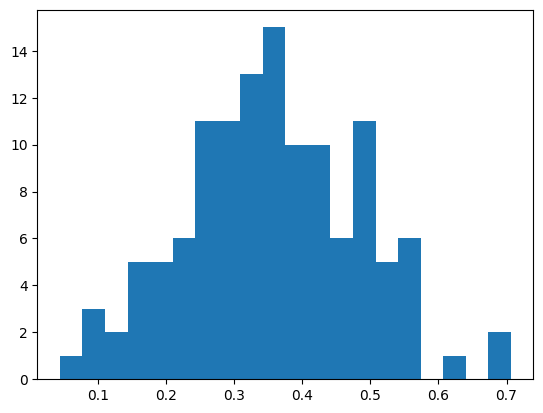

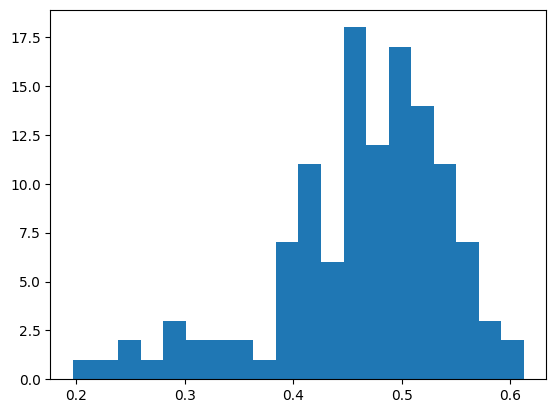

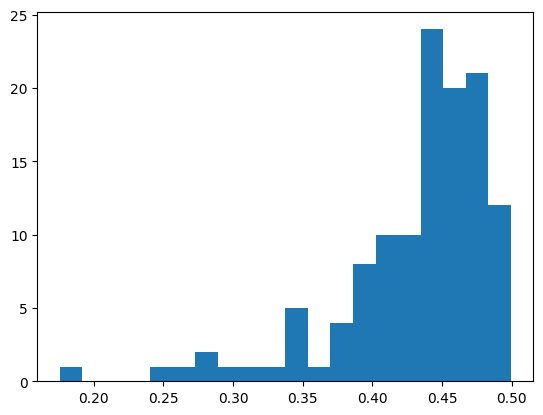

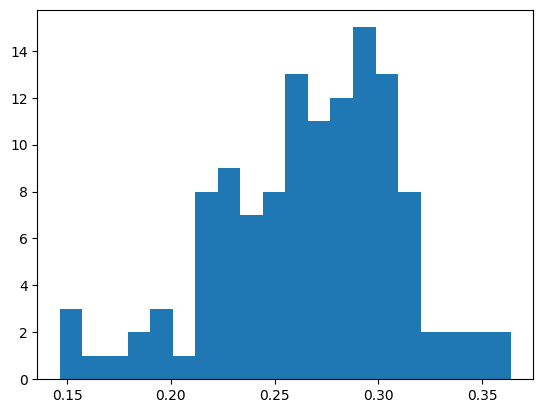

In [7]:
import matplotlib.pyplot as plt

plt.hist(stratified_art_df['avg_engagement_score'], bins=20)
plt.show()
plt.hist(stratified_art_df['avg_sentiment_score'], bins=20)
plt.show()
plt.hist(stratified_art_df['std_engagement_score'], bins=20)
plt.show()
plt.hist(stratified_art_df['std_sentiment_score'], bins=20)
plt.show()

In [8]:
def count_sentences(in_str):
    return len(in_str.split("."))


for row_idx, row in stratified_art_df.iterrows():
    c_art_id = row["article_id"]
    c_art_body = row['body']
    stratified_art_df.loc[row_idx, 'num_sentences'] = count_sentences(c_art_body)



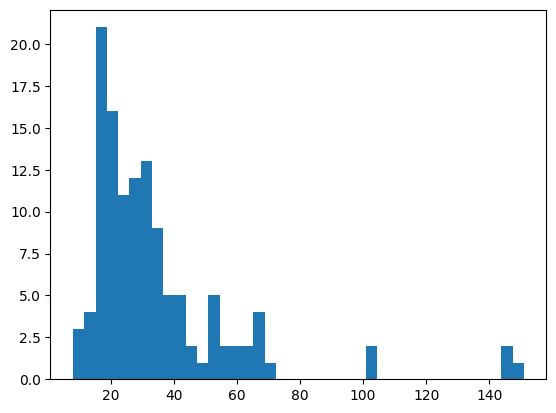

In [9]:
plt.hist(stratified_art_df['num_sentences'], bins=40)
plt.show()

In [12]:
top_n = 10

lowest_engagement_headlines = stratified_art_df.sort_values("engagement_score_sum", ascending=True)['headline'].values[:top_n]
highest_engagement_headlines = stratified_art_df.sort_values("engagement_score_sum", ascending=False)['headline'].values[:top_n]
lowest_sentiment_headlines = stratified_art_df.sort_values("sentiment_score_sum", ascending=True)['headline'].values[:top_n]
highest_sentiment_headlines = stratified_art_df.sort_values("sentiment_score_sum", ascending=False)['headline'].values[:top_n]

In [13]:
print("\n +++++ Lowest Engagement - Top 5 Headlines +++++ \n")
print(lowest_engagement_headlines)
print("\n +++++ Highest Engagement - Top 5 Headlines +++++ \n")
print(highest_engagement_headlines)
print("\n +++++ Lowest sentiment - Top 5 Headlines +++++ \n")
print(lowest_sentiment_headlines)
print("\n +++++ Highest sentiment - Top 5 Headlines +++++ \n")
print(highest_sentiment_headlines)




 +++++ Lowest Engagement - Top 5 Headlines +++++ 

["China launches 'unhackable', quantum-secured smartphone"
 'Microsoft Says Its Had a Breakthrough in Quantum Computer System'
 'Trump signs legislation to boost quantum computing research with $1.2 billion'
 'Amazon is opening a center for quantum networking research | Engadget'
 'Fluxonium qubits bring the creation of a quantum computer closer'
 'U.S. hatches plan to build a quantum Internet that might be unhackable'
 'Quantum tunneling in graphene advances the age of terahertz wireless communications'
 'SU(N) matter is about 3 billion times colder than deep space'
 'Ancient Namibian stone could hold key to future quantum computers'
 'Physicists Confirm The Existence of Time Crystals in Epic Quantum Computer Simulation']

 +++++ Highest Engagement - Top 5 Headlines +++++ 

['Quantum interaction: 10,000 times faster than light'
 'The case against dark matter'
 'Quantum Teleportation Enters the Real World'
 "Quantum 'spookiness' passe

: 

In [4]:
import torch
from torch import nn

kldiv = nn.functional.kl_div(torch.tensor([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]).log(), torch.tensor([[0.5, 0.5], [0.3, 0.7], [0.1, 0.9]]), reduction='none')
print(kldiv, kldiv.shape)

tensor([[ 0.0000,  0.0000],
        [-0.1532,  0.2355],
        [-0.1609,  0.5290]]) torch.Size([3, 2])
